In [218]:
import pandas as pd
import os

## Data Reading

In [219]:
df_mapping_no2_to_traffico = pd.read_csv("../../data/processed/mapping/no2_to_traffic_sensor_mapping.csv")

df_air_quality_and_locations = pd.read_parquet("../../data/processed/air/df_air_quality_and_locations_from_2013.parquet")

df_mapping = pd.read_csv('../../data/processed/mapping/no2_to_traffic_sensor_mapping.csv')

In [220]:
# Define the root directory for processed traffic data
root_dir = '../../data/processed/traffic'

# List to hold DataFrames
dataframes = []

# Iterate through all folders in the root directory
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    
    # Check if the folder exists and is a directory
    if os.path.isdir(folder_path):
        print(f"Processing folder: {folder_path}")
        
        # Iterate through all files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.parquet'):  # Ensure it's a Parquet file
                file_path = os.path.join(folder_path, file_name)
                
                # Read the Parquet file
                try:
                    df = pd.read_parquet(file_path)
                    print(f"Successfully read: {file_path} with {len(df)} rows.")
                    
                    # Append the DataFrame to the list
                    dataframes.append(df)
                    
                except Exception as e:
                    print(f"Error reading file {file_name}: {e}")

# Concatenate all DataFrames into one
if dataframes:  # Check if the list is not empty
    df_traffic = pd.concat(dataframes, ignore_index=True)
    print(f"Combined DataFrame created with {len(df_traffic)} rows.")

Processing folder: ../../data/processed/traffic/2022
Successfully read: ../../data/processed/traffic/2022/12-2022_processed.parquet with 48331 rows.
Successfully read: ../../data/processed/traffic/2022/11-2022_processed.parquet with 46722 rows.
Successfully read: ../../data/processed/traffic/2022/10-2022_processed.parquet with 47576 rows.
Successfully read: ../../data/processed/traffic/2022/01-2022_processed.parquet with 45047 rows.
Successfully read: ../../data/processed/traffic/2022/06-2022_processed.parquet with 42196 rows.
Successfully read: ../../data/processed/traffic/2022/05-2022_processed.parquet with 42735 rows.
Successfully read: ../../data/processed/traffic/2022/08-2022_processed.parquet with 45087 rows.
Successfully read: ../../data/processed/traffic/2022/02-2022_processed.parquet with 40460 rows.
Successfully read: ../../data/processed/traffic/2022/03-2022_processed.parquet with 44372 rows.
Successfully read: ../../data/processed/traffic/2022/09-2022_processed.parquet with

In [221]:
df_traffic = df_traffic.rename(columns = {'hora': 'fecha'})

## Data processing for NO2 Sensores

1. Eliminar del dataset todos los sensores que no esten dentro del dataset "df_mapping_no2_to_traffico".
para ello, compara del dataset df_mapping_no2_to_traffico columna id_no2 con dataset df_air_quality_and_locations "CODIGO".

In [222]:
# Filter df_air_quality_and_locations to keep only sensors present in df_mapping_no2_to_traffico
filtered_air_quality_data = df_air_quality_and_locations[
    df_air_quality_and_locations['CODIGO'].isin(df_mapping_no2_to_traffico['id_no2'])
]

In [223]:
# Get the length of the original DataFrame
original_count = len(df_air_quality_and_locations)

# Get the length of the filtered DataFrame
filtered_count = len(filtered_air_quality_data)

# Calculate the percentage of retained sensors
percentage_retained = (filtered_count / original_count) * 100

print(f'Number of original sensors: {original_count}')
print(f'Number of retained sensors: {filtered_count}')
print(f'Percentage of retained data: {percentage_retained:.2f}%')

Number of original sensors: 2490936
Number of retained sensors: 1343640
Percentage of retained data: 53.94%


Let's remove unnecesary columns:

In [224]:
unnecesary_cols = ['PROVINCIA','MUNICIPIO','ESTACION','MAGNITUD','PUNTO_MUESTREO','CODIGO_CORTO','LOCALIZACION','DIRECCION','COD_VIA','COD_TIPO']

In [225]:
df_air = filtered_air_quality_data.drop(columns = unnecesary_cols)
df_air.columns = df_air.columns.str.lower()
df_air = df_air.rename(columns = {'codigo':'id_no2'})

# Creating the main dataset

### Approach 1: keep the `ID_trafffic sensors` that appear in all the data

In [226]:
# Create a new dataframe with the following structure, for each unique traffic sensor (id_trafico)

# id_traffico, year, month, appears
# 3411, 2024, 11, true
# 3411, 2024, 12, false
df = df_traffic.copy()

# Convert fecha to datetime
df["fecha"] = pd.to_datetime(df["fecha"])

# Extract year and month
df["year"] = df["fecha"].dt.year
df["month"] = df["fecha"].dt.month

# Create the new DataFrame with unique combinations
result = df.groupby(["id_trafico", "year", "month"]).size().reset_index(name="count")


In [227]:
result['count'].mean()

np.float64(700.4623217922607)

In [228]:
# Add 'appears' column (True if there is data for that month)
result["appears"] = result["count"] > 500

# Drop the count column as it's not needed
result = result.drop(columns=["count"])

result.sort_values(by=['year', 'month', 'id_trafico'])

,id_trafico,year,month,appears
587,3411,2018,1,True
671,3513,2018,1,True
755,3730,2018,1,True
835,3731,2018,1,True
916,3732,2018,1,True
...,...,...,...,...
4585,6119,2024,12,True
4669,6123,2024,12,True
4747,6822,2024,12,True
4825,6823,2024,12,True


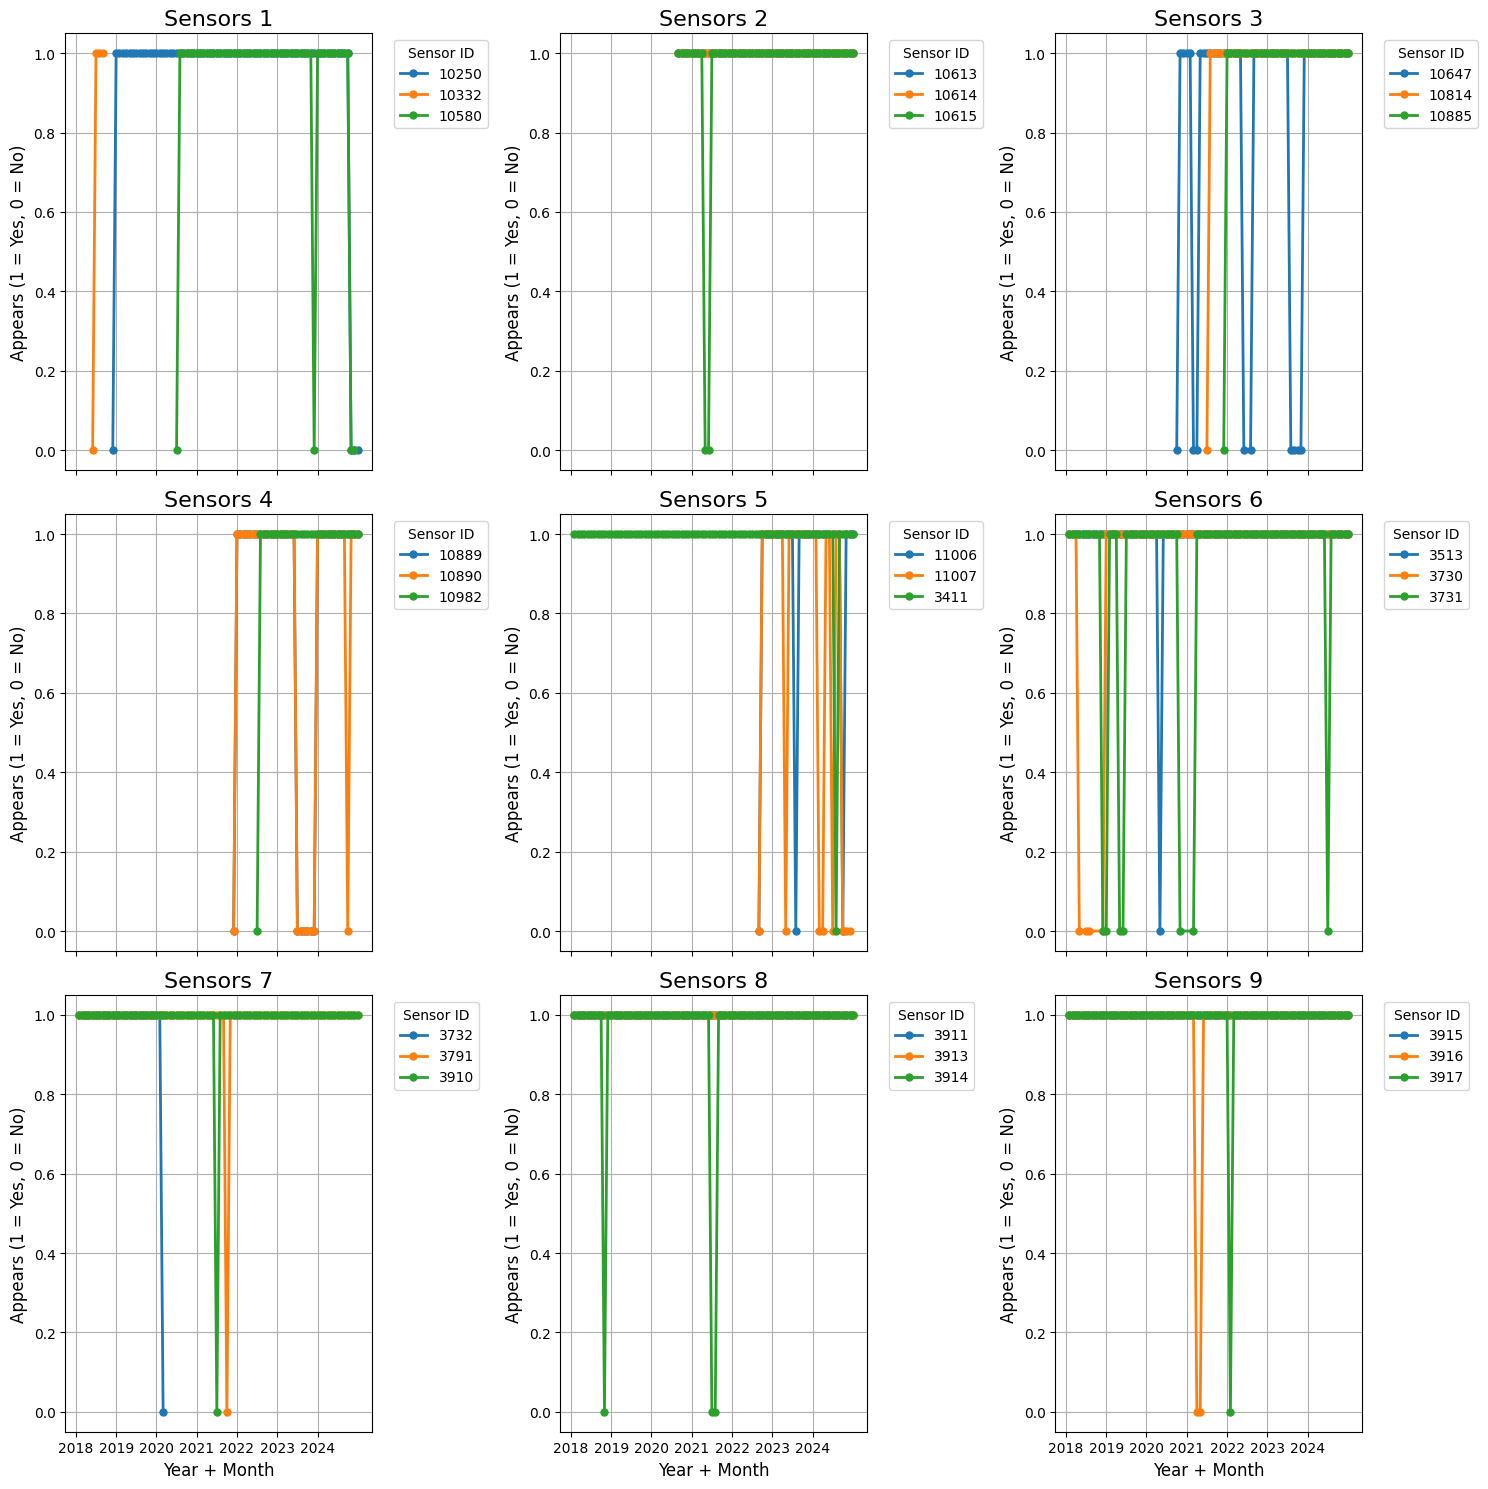

In [229]:
import matplotlib.pyplot as plt

df_plot = result.copy()

# Set 'appears' as 1 (True) or 0 (False)
df_plot['appears'] = df_plot['appears'].astype(int)

# Create subplots with 3 rows and 3 columns
num_plots = 9
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True)

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot each sensor's appearances over time in separate subplots
for i, sensor_id in enumerate(df_plot['id_trafico'].unique()):
    if i >= num_plots * 3:  # Limit to 9 plots with 3 sensors each
        break
    sensor_data = df_plot[df_plot['id_trafico'] == sensor_id]
    ax = axes[i // 3]  # Determine which subplot to use
    ax.plot(sensor_data['year'] + sensor_data['month'] / 12, sensor_data['appears'], marker='o', linestyle='-', linewidth=2, markersize=5, label=sensor_id)

    ax.set_title(f'Sensors {i // 3 + 1}', fontsize=16)
    ax.set_ylabel('Appears (1 = Yes, 0 = No)', fontsize=12)
    ax.grid(True)
    ax.legend(title='Sensor ID', bbox_to_anchor=(1.05, 1), loc='upper left')

# Labeling the x-axis for the bottom row
for ax in axes[-3:]:  # Only label the bottom row
    ax.set_xlabel('Year + Month', fontsize=12)
    ax.set_xticks(range(2018, 2025))
    ax.set_xticklabels([f'{y}' for y in range(2018, 2025)])

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

now, lets keep only the ones that always are true!

In [230]:
always_true_ids = result.groupby('id_trafico')['appears'].all()

# Filter to keep only id_trafico where 'appears' is always True
ids_always_true = always_true_ids[always_true_ids].index.tolist()
ids_always_true_int = [int(id) for id in ids_always_true]

print(ids_always_true) 

['10613', '10614', '3911', '3913', '3915', '4129', '4333', '4461', '4469', '4555', '5084', '5414', '5465', '5547', '5783']


In [231]:
# Now, filter the original DataFrame to keep only these id_trafico values
df_traffic = df_traffic[df_traffic['id_trafico'].isin(ids_always_true)]

In [232]:
df_mapping = df_mapping[df_mapping['id_trafico'].isin(ids_always_true_int)].sort_values(by='id_trafico')

In [233]:
df_mapping

,id_no2,id_trafico,distance_m
15,28079011,3911,63
20,28079011,3913,63
16,28079011,3915,63
48,28079047,4129,166
1,28079004,4333,71
50,28079048,4461,111
49,28079048,4469,111
40,28079039,4555,61
64,28079056,5084,24
38,28079039,5414,61


### Approach 2: For each `NO2 sensor`, keep the closest `Traffic sensor`

done, there is only 1 id_traffic per sensor

In [234]:
df_air['id_no2'] = df_air['id_no2'].astype(str)
df_mapping['id_trafico'] = df_mapping['id_trafico'].astype(str)
df_mapping['id_no2'] = df_mapping['id_no2'].astype(str)

In [235]:
# keep only from > 2018 data by looking at col fecha
df_air['fecha'] = pd.to_datetime(df_air['fecha'], errors='coerce')
df_traffic['fecha'] = pd.to_datetime(df_traffic['fecha'], errors='coerce')

df_air = df_air[df_air['fecha'] >= '2018-01-01']

In [236]:
len(df_air)

775453

In [237]:
# Keep only one id_no2 for each unique id_no2 with the minimum distance_m
df_mapping = df_mapping.loc[df_mapping.groupby('id_no2')['distance_m'].idxmin()]

In [238]:
df = pd.merge(df_air, df_mapping, how = 'left', left_on='id_no2', right_on='id_no2')

In [239]:
df = pd.merge(df, df_traffic, how = 'left', left_on=['id_trafico','fecha'], right_on=['id_trafico','fecha'])

In [240]:
df = df.dropna()

# Keep only one sensor as an example

In [258]:
def plot_no2(df, id, min_date, max_date):

    df_test = df[df['id_no2'] == id]

    # Ensure 'fecha' is in datetime format
    df_test['fecha'] = pd.to_datetime(df_test['fecha'])


    # Filter for the date range
    daily_data = df_test[(df_test['fecha'] >= pd.to_datetime(min_date)) & 
                        (df_test['fecha'] <= pd.to_datetime(max_date))]

    # Create subplots
    fig, axs = plt.subplots(3, 1, figsize=(10, 15))

    # Plot NO2 Value and Intensidad
    ax1 = axs[0]
    ax1.plot(daily_data['fecha'], daily_data['no2_value'], marker='o', linestyle='-', color='b', label='NO2 Value')
    ax1.set_ylabel('NO2 Value', fontsize=12, color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_title('NO2 Value and Intensidad', fontsize=14)
    ax1.grid(True)

    # Create a secondary y-axis for Intensidad
    ax2 = ax1.twinx()
    ax2.plot(daily_data['fecha'], daily_data['intensidad'], marker='x', linestyle='--', color='r', label='Intensidad')
    ax2.set_ylabel('Intensidad', fontsize=12, color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Plot NO2 Value and Carga
    ax3 = axs[1]
    ax3.plot(daily_data['fecha'], daily_data['no2_value'], marker='o', linestyle='-', color='b', label='NO2 Value')
    ax3.set_ylabel('NO2 Value', fontsize=12, color='b')
    ax3.tick_params(axis='y', labelcolor='b')
    ax3.set_title('NO2 Value and Carga', fontsize=14)
    ax3.grid(True)

    # Create a secondary y-axis for Carga
    ax4 = ax3.twinx()
    ax4.plot(daily_data['fecha'], daily_data['carga'], marker='s', linestyle=':', color='g', label='Carga')
    ax4.set_ylabel('Carga', fontsize=12, color='g')
    ax4.tick_params(axis='y', labelcolor='g')

    # Plot NO2 Value and Ocupacion
    ax5 = axs[2]
    ax5.plot(daily_data['fecha'], daily_data['no2_value'], marker='o', linestyle='-', color='b', label='NO2 Value')
    ax5.set_ylabel('NO2 Value', fontsize=12, color='b')
    ax5.tick_params(axis='y', labelcolor='b')
    ax5.set_title('NO2 Value and Ocupacion', fontsize=14)
    ax5.grid(True)

    # Create a secondary y-axis for Ocupacion
    ax6 = ax5.twinx()
    ax6.plot(daily_data['fecha'], daily_data['ocupacion'], marker='^', linestyle='-.', color='m', label='Ocupacion')
    ax6.set_ylabel('Ocupacion', fontsize=12, color='m')
    ax6.tick_params(axis='y', labelcolor='m')

    # Adjust layout
    plt.tight_layout()
    plt.show()

/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_97722/32182765.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['fecha'] = pd.to_datetime(df_test['fecha'])


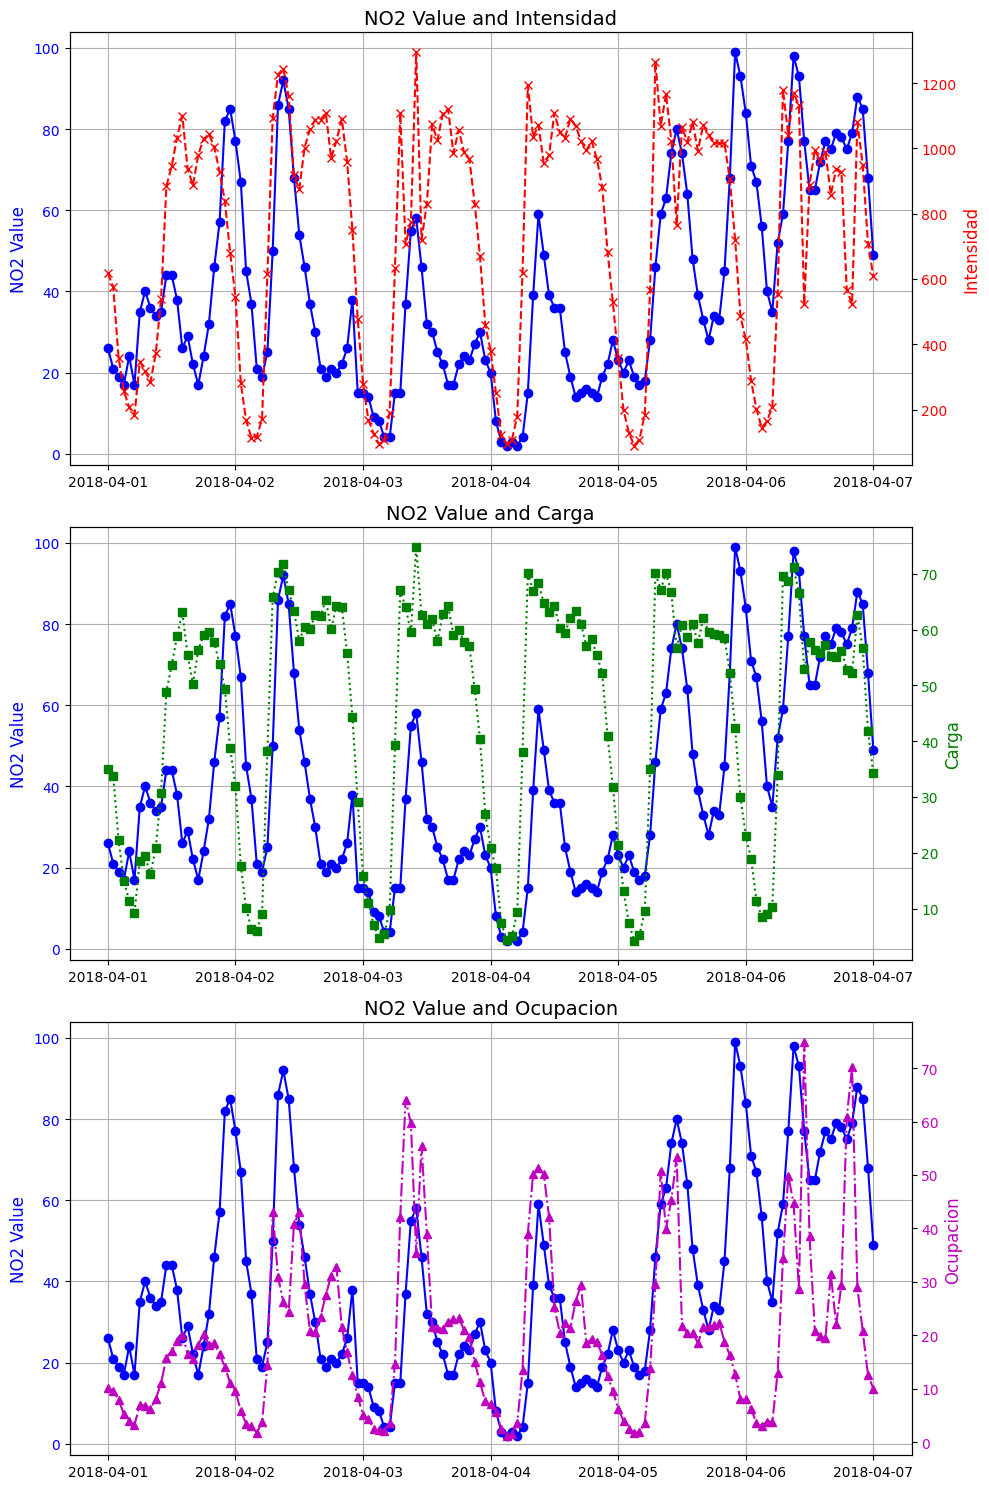

In [257]:
plot_no2(df, '28079004',min_date = '2018-04-01', max_date = '2018-04-07')